# Testes iniciais: exemplo do livro (atrator de Lorenz)

In [1]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from pprint import pprint
import pandas as pd
import itertools

In [2]:
# Prevenindo o uso de GPU (não compensa -- overhead maior que ganho)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# seed para reprodutibilidade
np.random.seed(6661)

## Redes neurais

### Feedforward

In [4]:
dt = 0.01; T = 8; t = np.arange(0,T+dt,dt)
beta = 8/3; sigma = 10; rho = 28
nn_input = np.zeros((100*(len(t)-1),3))
nn_output = np.zeros_like(nn_input)

def lorenz_deriv(x_y_z,t0,sigma=sigma,beta=beta,rho=rho):
    x, y, z = x_y_z
    return [sigma*(y-x), x*(rho-z)-y, x*y-beta*z]

x0 = -15 + 30 * np.random.random((100, 3))
x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t) for x0_j in x0])

for j in range(100):
    nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
    nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]

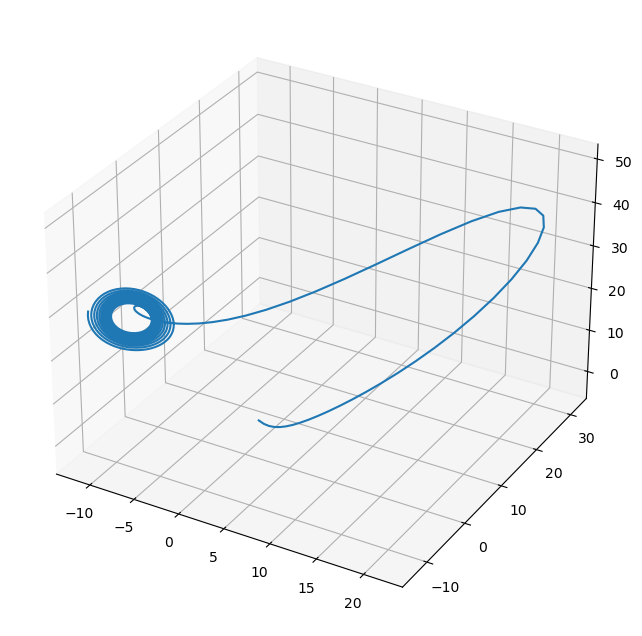

In [5]:
# (100, 801, 3)
# 100 trajetórias, 801 pontos, 3 dimensões
# plot de uma trajetória (3d)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(projection='3d')
ax.plot(x_t[0,:,0], x_t[0,:,1], x_t[0,:,2])
plt.show()

In [6]:
net = keras.models.Sequential()
net.add(layers.Dense(10, input_dim=3, activation='sigmoid'))
net.add(layers.Dense(10, activation='relu'))
net.add(layers.Dense(3, activation='linear'))
net.compile(loss='mse', optimizer='adam')
History = net.fit(nn_input, nn_output, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 2s 697us/step - loss: 43.6308
Epoch 2/30
2500/2500 [==============================] - 2s 686us/step - loss: 1.7233
Epoch 3/30
2500/2500 [==============================] - 2s 686us/step - loss: 0.5948
Epoch 4/30
2500/2500 [==============================] - 2s 690us/step - loss: 0.2986
Epoch 5/30
2500/2500 [==============================] - 2s 679us/step - loss: 0.1812
Epoch 6/30
2500/2500 [==============================] - 2s 702us/step - loss: 0.1162
Epoch 7/30
2500/2500 [==============================] - 2s 737us/step - loss: 0.0824
Epoch 8/30
2500/2500 [==============================] - 2s 726us/step - loss: 0.0626
Epoch 9/30
2500/2500 [==============================] - 2s 687us/step - loss: 0.0499
Epoch 10/30
2500/2500 [==============================] - 2s 754us/step - loss: 0.0408
Epoch 11/30
2500/2500 [==============================] - 2s 702us/step - loss: 0.0343
Epoch 12/30
2500/2500 [==============================] - 2s 72

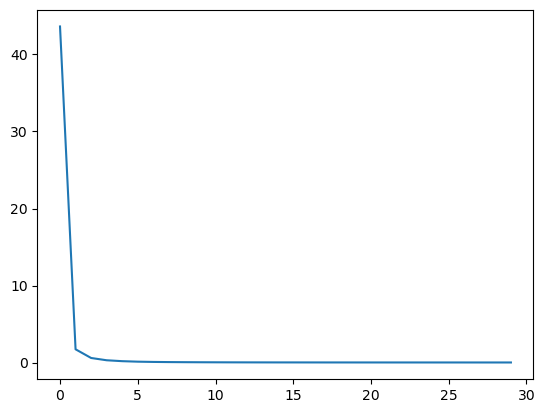

In [7]:
# plot loss history
plt.plot(History.history['loss'])

Melhor do que tentar prever próximos estados destas trajetórias existentes, vamos tentar prever o comportamento de duas trajetórias completamente novas (mas integrantes ao sistema para qual a rede foi treinada).

In [8]:
# 2 trajetórias
num_traj = 2

ynn = np.zeros((num_traj, len(t), 3))
np.random.seed(6661)
ynn[:, 0, :] = -15 + 30 * np.random.random((num_traj, 3))
print(ynn.shape)
for jj, tval in enumerate(t[:-1]):
    ynn[:, jj+1, :] = net.predict(ynn[:, jj, :], verbose=1)

(2, 801, 3)
1/1 [==============================] - 0s 15ms/step


In [9]:
ynn.shape

(2, 801, 3)

In [10]:
# solve ODE, the two trajectories
y_t_1 = integrate.odeint(lorenz_deriv, ynn[0, 0, :], t)
y_t_2 = integrate.odeint(lorenz_deriv, ynn[1, 0, :], t)
y_t_1

array([[ -1.57116946,   6.99253458,  -5.41252538],
       [ -0.78044271,   6.53599775,  -5.34779949],
       [ -0.09606072,   6.32836109,  -5.23435835],
       ...,
       [-11.17154449, -12.79385865,  28.47210896],
       [-11.31599229, -12.5764761 ,  29.13134296],
       [-11.42250924, -12.28725985,  29.76049747]])

In [11]:
y_t_2

array([[ 11.28811616, -13.43241084,  12.32630939],
       [  9.02420987, -11.63957892,  10.74939111],
       [  7.13454388, -10.09556193,   9.60321385],
       ...,
       [  5.63888205,   8.5555115 ,  17.44123782],
       [  5.94149621,   9.0775073 ,  17.48601177],
       [  6.2661252 ,   9.62272318,  17.58905534]])

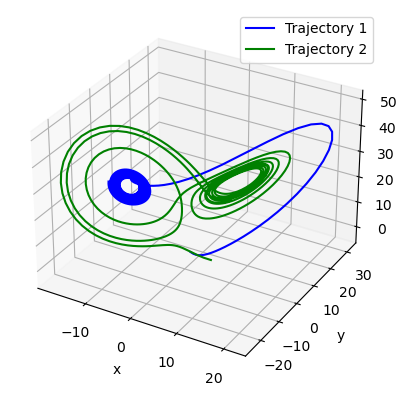

In [12]:
# plot y_t_1 and y_t_2 (blue and green)
# 3d
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(y_t_1[:, 0], y_t_1[:, 1], y_t_1[:, 2], 'b')
ax.plot(y_t_2[:, 0], y_t_2[:, 1], y_t_2[:, 2], 'g')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# blue label = trajectory 1
# green label = trajectory 2
plt.legend(['Trajectory 1', 'Trajectory 2'])
plt.show()

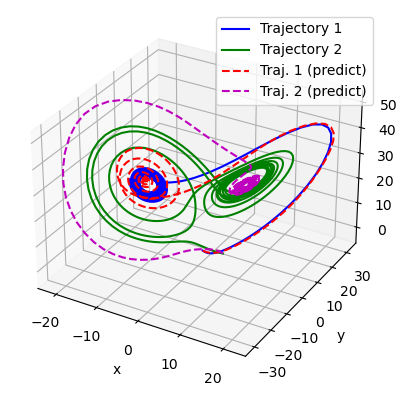

In [13]:
# plot y_t_1 and y_t_2 (blue and green)
# 3d
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(y_t_1[:, 0], y_t_1[:, 1], y_t_1[:, 2], 'b')
ax.plot(y_t_2[:, 0], y_t_2[:, 1], y_t_2[:, 2], 'g')
# ynn = np.zeros((num_traj, len(t), 3))
ynn_1 = ynn[0, :, :]
ynn_2 = ynn[1, :, :]
# plot ynn_1 (red, dotted line)
ax.plot(ynn_1[:, 0], ynn_1[:, 1], ynn_1[:, 2], 'r--')
# plot ynn_2 (pink, dotted line)
ax.plot(ynn_2[:, 0], ynn_2[:, 1], ynn_2[:, 2], 'm--')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# blue label = trajectory 1
# green label = trajectory 2
plt.legend(['Trajectory 1', 'Trajectory 2', 'Traj. 1 (predict)', 'Traj. 2 (predict)'])
plt.show()

In [14]:
# TODO: comentar melhor

### RNN (LSTM)

In [17]:
sequence_size = 40; train_size = 80; test_size = 20

rnn_input = np.zeros((train_size*(len(t)-sequence_size-1), sequence_size, 3))
rnn_output = np.zeros((train_size*(len(t)-sequence_size-1), 3))

for j in range(train_size):
    for k in range(len(t)-sequence_size-1):
        rnn_input[j*(len(t)-sequence_size-1) + k,:] = x_t[j,k:k+sequence_size,:]
        rnn_output[j*(len(t)-sequence_size-1) + k,:] = x_t[j,k+sequence_size,:]

model = keras.models.Sequential()
model.add(layers.LSTM(16, input_shape=(None, 3)))
# model.add(SimpleRNN(16, input_shape=(None, 3)))
model.add(layers.Dense(3))
sgd = optimizers.SGD(0.01)
model.compile(optimizer=sgd, loss='mean_squared_error')

In [18]:
model.fit(rnn_input, rnn_output, epochs=50)

Epoch 1/10
1900/1900 [==============================] - 11s 5ms/step - loss: 9.5691
Epoch 2/10
1900/1900 [==============================] - 10s 5ms/step - loss: 1.5780
Epoch 3/10
1900/1900 [==============================] - 10s 5ms/step - loss: 0.9677
Epoch 4/10
1900/1900 [==============================] - 10s 5ms/step - loss: 0.6792
Epoch 5/10
1900/1900 [==============================] - 10s 5ms/step - loss: 0.5396
Epoch 6/10
1900/1900 [==============================] - 10s 5ms/step - loss: 0.4650
Epoch 7/10
1900/1900 [==============================] - 10s 5ms/step - loss: 0.3833
Epoch 8/10
1900/1900 [==============================] - 10s 5ms/step - loss: 0.3461
Epoch 9/10
1900/1900 [==============================] - 10s 5ms/step - loss: 0.3122
Epoch 10/10
1900/1900 [==============================] - 10s 5ms/step - loss: 0.2720


In [19]:
first_point = -15 + 30 * np.random.random((1, 3))
ynn = np.zeros((1, test_size, 3))
ynn[0, 0, :] = first_point

In [20]:
# solve ODE for the first point
y_t = integrate.odeint(lorenz_deriv, ynn[0, 0, :], t[:test_size])
y_t.shape

(20, 3)

In [21]:
for i in range(1, test_size):
    prediction = model.predict(ynn[:, :i, :])
    ynn[:, i, :] = prediction

1/1 [==============================] - 0s 17ms/step


In [22]:
ynn.shape

(1, 20, 3)

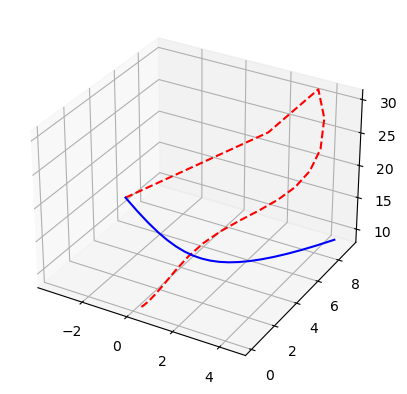

In [23]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot(ynn[0, :, 0], ynn[0, :, 1], ynn[0, :, 2], 'r--')
ax.plot(y_t[:, 0], y_t[:, 1], y_t[:, 2], 'b')
plt.show()

## Métodos numéricos

### SINDy

In [24]:
dt = 0.01
T = 50
t = np.arange(dt,T+dt,dt)
beta = 8/3
sigma = 10
rho = 28
n = 3

def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

np.random.seed(123)
x0 = (-8,8,27)

x = integrate.odeint(lorenz_deriv, x0, t,rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))

In [25]:
## Compute Derivative
dx = np.zeros_like(x)
for j in range(len(t)):
    dx[j,:] = lorenz_deriv(x[j,:],0,sigma,beta,rho)

In [26]:
## SINDy Function Definitions

def poolData(yin,nVars,polyorder):
    n = yin.shape[0]
    yout = np.zeros((n,1))
    
    # poly order 0
    yout[:,0] = np.ones(n)
    
    # poly order 1
    for i in range(nVars):
        yout = np.append(yout,yin[:,i].reshape((yin.shape[0],1)),axis=1)
    
    # poly order 2
    if polyorder >= 2:
        for i in range(nVars):
            for j in range(i,nVars):
                yout = np.append(yout,(yin[:,i]*yin[:,j]).reshape((yin.shape[0],1)),axis=1)
                
    # poly order 3
    if polyorder >= 3:
        for i in range(nVars):
            for j in range(i,nVars):
                for k in range(j,nVars):
                    yout = np.append(yout,(yin[:,i]*yin[:,j]*yin[:,k]).reshape((yin.shape[0],1)),axis=1)
    
    return yout

def sparsifyDynamics(Theta,dXdt,lamb,n):
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0] # Initial guess: Least-squares
    
    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coefficients
        Xi[smallinds] = 0                          # and threshold
        for ind in range(n):                       # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress dynamics onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,biginds],dXdt[:,ind],rcond=None)[0]
            
    return Xi

In [27]:
Theta = poolData(x,n,3) # Up to third order polynomials
lamb = 0.025 # sparsification knob lambda
Xi = sparsifyDynamics(Theta,dx,lamb,n)
print(Xi.shape)
df_theta = pd.DataFrame(Theta)
df_theta

(20, 3)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.0,-8.000000,8.000000,27.000000,64.000000,-64.000000,-216.000000,64.000000,216.000000,729.000000,-512.000000,512.000000,1728.000000,-512.000000,-1728.000000,-5832.000000,512.000000,1728.000000,5832.000000,19683.000000
1,1.0,-6.486403,7.803171,25.725523,42.073424,-50.614509,-166.866108,60.889470,200.740640,661.802514,-272.905189,328.306106,1082.360833,-394.953645,-1302.084697,-4292.717843,475.130919,1566.413443,5164.157869,17025.215547
2,1.0,-5.138018,7.562589,24.608811,26.399226,-38.856716,-126.440505,57.192752,186.106322,605.593566,-135.639688,199.646494,649.653548,-293.857373,-956.217570,-3111.550447,432.525281,1407.445620,4579.855244,14902.937456
3,1.0,-3.941506,7.312988,23.628928,15.535471,-28.824189,-93.133568,53.479799,172.798079,558.326262,-61.233156,113.610720,367.086538,-210.790959,-681.084702,-2200.646428,391.097147,1263.670343,4083.033459,13192.651320
4,1.0,-2.882048,7.078172,22.765711,8.306202,-20.399632,-65.611874,50.100515,161.139609,518.277583,-23.938873,58.792721,189.096582,-144.392096,-464.412114,-1493.700952,354.620046,1140.573824,3668.457726,11798.957507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1.0,-5.909059,0.308672,31.346754,34.916981,-1.823959,-185.229827,0.095278,9.675852,982.619009,-206.326506,10.777879,1094.534016,-0.563004,-57.175179,-5806.353899,0.029410,2.986660,303.306541,30801.916724
4996,1.0,-5.309083,0.468948,30.500139,28.186359,-2.489683,-161.927761,0.219912,14.302973,930.258488,-149.643710,13.217931,859.687870,-1.167531,-75.935668,-4938.819230,0.103127,6.707348,436.242675,28373.013334
4997,1.0,-4.753966,0.568886,29.671623,22.600193,-2.704462,-141.057886,0.323631,16.879756,880.405186,-107.440551,12.856922,670.584404,-1.538529,-80.245788,-4185.416368,0.184109,9.602649,500.849753,26123.050386
4998,1.0,-4.244606,0.620165,28.864326,18.016682,-2.632355,-122.517696,0.384604,17.900640,833.149297,-76.473720,11.173313,520.039376,-1.632494,-75.981166,-3536.390689,0.238518,11.101347,516.689892,24048.292667


In [28]:
Xi

array([[  0.        ,   0.        ,   0.        ],
       [-10.        ,  28.        ,   0.        ],
       [ 10.        ,  -1.        ,   0.        ],
       [  0.        ,   0.        ,  -2.66666667],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   1.        ],
       [  0.        ,  -1.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ],
       [  0.        ,   0.     

Percebe-se aqui o sistema identificado pelo SINDy:

$$\dot{x} = -10x + 10y$$
$$\dot{y} = 28x - y - xz$$
$$\dot{z} = - \frac{8}{3}z + xy$$

exatamente o sistema para qual foi treinado, o que demonstra a capacidade de identificação de um sistema dinâmico pelo SINDy somente a partir dos dados de entrada e saída, dada uma dimensionalidade (no caso, $n = 3$). Claro, neste caso exemplo, isto não é exatamente impressionante, já que as entradas foram o sistema e sua resolução exatas. Situações mais interessantes poderão ser percebidas quando tratar-se de fenômenos cuja modelagem é inexistente/as dinâmicas são desconhecidas.

In [29]:
# Recriando sistema em matriz, resolve a partir do ponto inicial xo
def sindy_system_solve(inputs, t0):
    # Decompõe o inputs em um vetor
    inputs = np.array(inputs).reshape(-1)
    # Neste ponto é necessário conhecer as funções candidatas para progredir
    # E saber como remontar o sistema. Um possível TODO é criar uma relação na geração das candidatas que possa
    # ser reaproveitada nesta função. Aqui, reproduzo as candidatas manualmente.
    candi_vet = np.array([1])
    # Add inputs
    candi_vet = np.append(candi_vet, inputs)
    # Combinação de inputs até ordem 3
    k = 2
    while candi_vet.shape[0] < 20:
        # TODO: otimizável?
        combinations = np.indices((len(inputs),) * k).reshape((k, -1)).T
        unique_combinations = np.unique(np.sort(combinations, axis=1), axis=0)
        selected_combinations = inputs[unique_combinations]
        result = np.prod(selected_combinations, axis=1)
        candi_vet = np.append(candi_vet, result)
        k += 1
    # Tomando a dimensionaliade do sistema como o número de colunas de Xi
    n = Xi.shape[1]
    res = np.zeros(n)
    for i in range(n):
        # Xi[:, i] é a coluna i de Xi, altamente esparasa. Confio que o numpy tenha uma otimização para isso. :)
        res[i] = np.dot(Xi[:, i], candi_vet)
    return res

In [30]:
# Remontando o sistema
# (não uso esta função)
def lorenz_by_sindy(x_y_z, t0):
    x, y, z = x_y_z
    d_x = -10 * x + 10 * y
    d_y = 28 * x - 1 * y - 1 * x * z
    d_z = -2.66666667* z + 1 * x * y # -8/3 = -2.66666667
    return [d_x, d_y, d_z]
# (sistema remotando perfeitamente)

In [31]:
# Rodando para o mesmo x0 = (-8,8,27)
x_sindy = integrate.odeint(sindy_system_solve, x0, t,rtol=10**(-12),atol=10**(-12)*np.ones_like(x0))

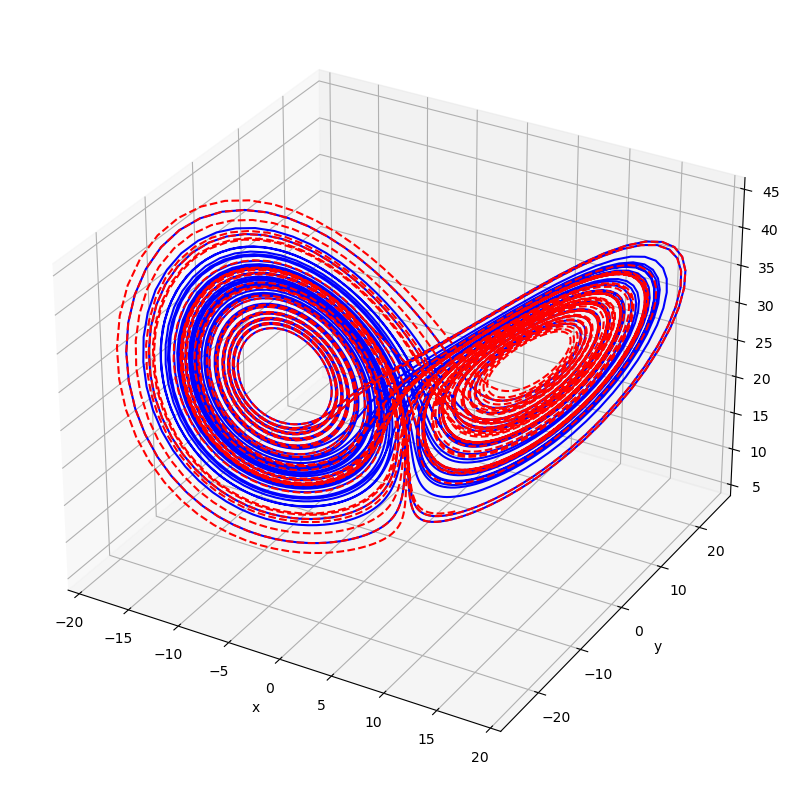

In [32]:
# 3D plot: x_sindy (Dashed) vs x (Solid)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.plot(x[:, 0], x[:, 1], x[:, 2], 'b')
ax.plot(x_sindy[:, 0], x_sindy[:, 1], x_sindy[:, 2], 'r--')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [33]:
# TODO: 100 trajetórias!